In [ ]:
#!sudo apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 0s (35.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122519 files and dir

In [ ]:
#!sudo fc-cache -fv

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director

In [ ]:
#!rm ~/.cache/matplotlib -rf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
## Hyperparameter Setting

CFG = {
    'IMG_SIZE':224,
    'EPOCHS': 30,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':128,
    'SEED': 41
}

In [ ]:
# get dataset
all_img_list = glob.glob('drive/MyDrive/Doedal/train/*/*')
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[4])

In [ ]:
df

,img_path,label
0,drive/MyDrive/Doedal/train/걸레받이수정/111...,걸레받이수정
1,drive/MyDrive/Doedal/train/걸레받이수정/11.png,걸레받이수정
2,drive/MyDrive/Doedal/train/걸레받이수정/175...,걸레받이수정
3,drive/MyDrive/Doedal/train/걸레받이수정/178...,걸레받이수정
4,drive/MyDrive/Doedal/train/걸레받이수정/20.png,걸레받이수정
...,...,...
3452,drive/MyDrive/Doedal/train/틈새과다/1.png,틈새과다
3453,drive/MyDrive/Doedal/train/틈새과다/4.png,틈새과다
3454,drive/MyDrive/Doedal/train/틈새과다/3.png,틈새과다
3455,drive/MyDrive/Doedal/train/틈새과다/2.png,틈새과다


In [ ]:
# 라벨 인코더 생성
encoder = LabelEncoder()

# X_train데이터를 이용 피팅하고 라벨숫자로 변환
encoder.fit(df['label'])
new_label = encoder.transform(df['label'])

In [ ]:
new_label

array([ 1,  1,  1, ..., 16, 16, 16])

In [ ]:
df['label'] = new_label
df

,img_path,label
0,drive/MyDrive/Doedal/train/걸레받이수정/111...,1
1,drive/MyDrive/Doedal/train/걸레받이수정/11.png,1
2,drive/MyDrive/Doedal/train/걸레받이수정/175...,1
3,drive/MyDrive/Doedal/train/걸레받이수정/178...,1
4,drive/MyDrive/Doedal/train/걸레받이수정/20.png,1
...,...,...
3452,drive/MyDrive/Doedal/train/틈새과다/1.png,16
3453,drive/MyDrive/Doedal/train/틈새과다/4.png,16
3454,drive/MyDrive/Doedal/train/틈새과다/3.png,16
3455,drive/MyDrive/Doedal/train/틈새과다/2.png,16


In [ ]:
# split train val dataset
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, stratify=df['label'], random_state=CFG['SEED'])

In [ ]:
## Label-Encoding
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

In [ ]:
## CustomDataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [ ]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5),
                            A.RandomBrightnessContrast(p=0.5),
                            #A.VerticalFlip(p=0.5),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [ ]:
#weighted sampling
a_list = train['label'].value_counts()
class_counts = train['label'].value_counts().to_list()
class_weights = [1 / a_list[i] for i in range(len(class_counts))]
num_samples = sum(class_counts)
labels_lists = train['label'].to_list()
weights = [class_weights[labels_lists[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples), replacement=True)

In [ ]:
# make dataloader
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], sampler=sampler, shuffle=False, num_workers=2)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

In [ ]:
## Model Define
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True) #densenet161(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha]*19)
        self.alpha[18] = 1-alpha
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
## Train

def trains(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
#     criterion = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
    criterion = FocalLoss(gamma=2, alpha=0.25)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

In [ ]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

In [ ]:
#init model
model = BaseModel()

In [ ]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = trains(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.30478] Val Loss : [0.45829] Val Weighted F1 Score : [0.54520]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.09217] Val Loss : [0.28202] Val Weighted F1 Score : [0.62624]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.04923] Val Loss : [0.28297] Val Weighted F1 Score : [0.65430]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.03180] Val Loss : [0.23017] Val Weighted F1 Score : [0.67141]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.02516] Val Loss : [0.24042] Val Weighted F1 Score : [0.67177]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.02053] Val Loss : [0.22846] Val Weighted F1 Score : [0.70629]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.01693] Val Loss : [0.22843] Val Weighted F1 Score : [0.70938]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.02201] Val Loss : [0.21032] Val Weighted F1 Score : [0.70802]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.01662] Val Loss : [0.19782] Val Weighted F1 Score : [0.71878]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.01681] Val Loss : [0.22237] Val Weighted F1 Score : [0.71760]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.01333] Val Loss : [0.21791] Val Weighted F1 Score : [0.73028]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.01668] Val Loss : [0.19448] Val Weighted F1 Score : [0.75342]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.01062] Val Loss : [0.18407] Val Weighted F1 Score : [0.73537]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.01074] Val Loss : [0.20115] Val Weighted F1 Score : [0.72667]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.01024] Val Loss : [0.18908] Val Weighted F1 Score : [0.74994]
Epoch 00015: reducing learning rate of group 0 to 1.5000e-04.


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.00813] Val Loss : [0.18821] Val Weighted F1 Score : [0.72968]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.00617] Val Loss : [0.17885] Val Weighted F1 Score : [0.75086]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.00494] Val Loss : [0.17624] Val Weighted F1 Score : [0.75681]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.00526] Val Loss : [0.17969] Val Weighted F1 Score : [0.74411]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.00504] Val Loss : [0.17753] Val Weighted F1 Score : [0.77401]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.00383] Val Loss : [0.18369] Val Weighted F1 Score : [0.76317]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.00388] Val Loss : [0.18267] Val Weighted F1 Score : [0.76785]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.00787] Val Loss : [0.18670] Val Weighted F1 Score : [0.77567]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.00283] Val Loss : [0.18595] Val Weighted F1 Score : [0.76087]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.00337] Val Loss : [0.18455] Val Weighted F1 Score : [0.74703]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.00336] Val Loss : [0.19908] Val Weighted F1 Score : [0.77954]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.00381] Val Loss : [0.19698] Val Weighted F1 Score : [0.76172]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.00348] Val Loss : [0.19376] Val Weighted F1 Score : [0.77315]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.00354] Val Loss : [0.19575] Val Weighted F1 Score : [0.76351]
Epoch 00029: reducing learning rate of group 0 to 7.5000e-05.


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.00267] Val Loss : [0.19939] Val Weighted F1 Score : [0.75925]


In [ ]:
preds = []
true = []
inference_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=2)
with torch.no_grad() :
    for img, label in inference_loader :
        img = img.float().to(device)
        label = label.to(device)
        pred = infer_model(img)
        
        preds.extend(pred.argmax(1).detach().cpu().numpy())
        true.extend(label.detach().cpu().numpy().tolist())

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import confusion_matrix

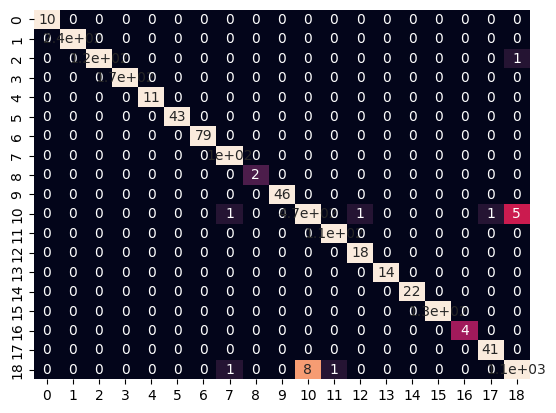

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(confusion_matrix(true, preds), annot=True, vmax = 10, vmin=0, cbar=False)
plt.show()

In [ ]:
train['pred'] = preds
train['true'] = true

In [ ]:
train.head()

,img_path,label,pred,true
343,./train/훼손/287.png,18,18,18
423,./train/훼손/1277.png,18,18,18
822,./train/훼손/1384.png,18,18,18
1213,./train/훼손/27.png,18,18,18
1662,./train/오염/21.png,10,10,10


In [ ]:
train['err'] = train['pred'] == train['label']

In [ ]:
err_ds = train.loc[(train['err'] == False)].copy()

In [ ]:
img_err = err_ds['img_path'].values

IndexError: index 19 is out of bounds for axis 0 with size 19

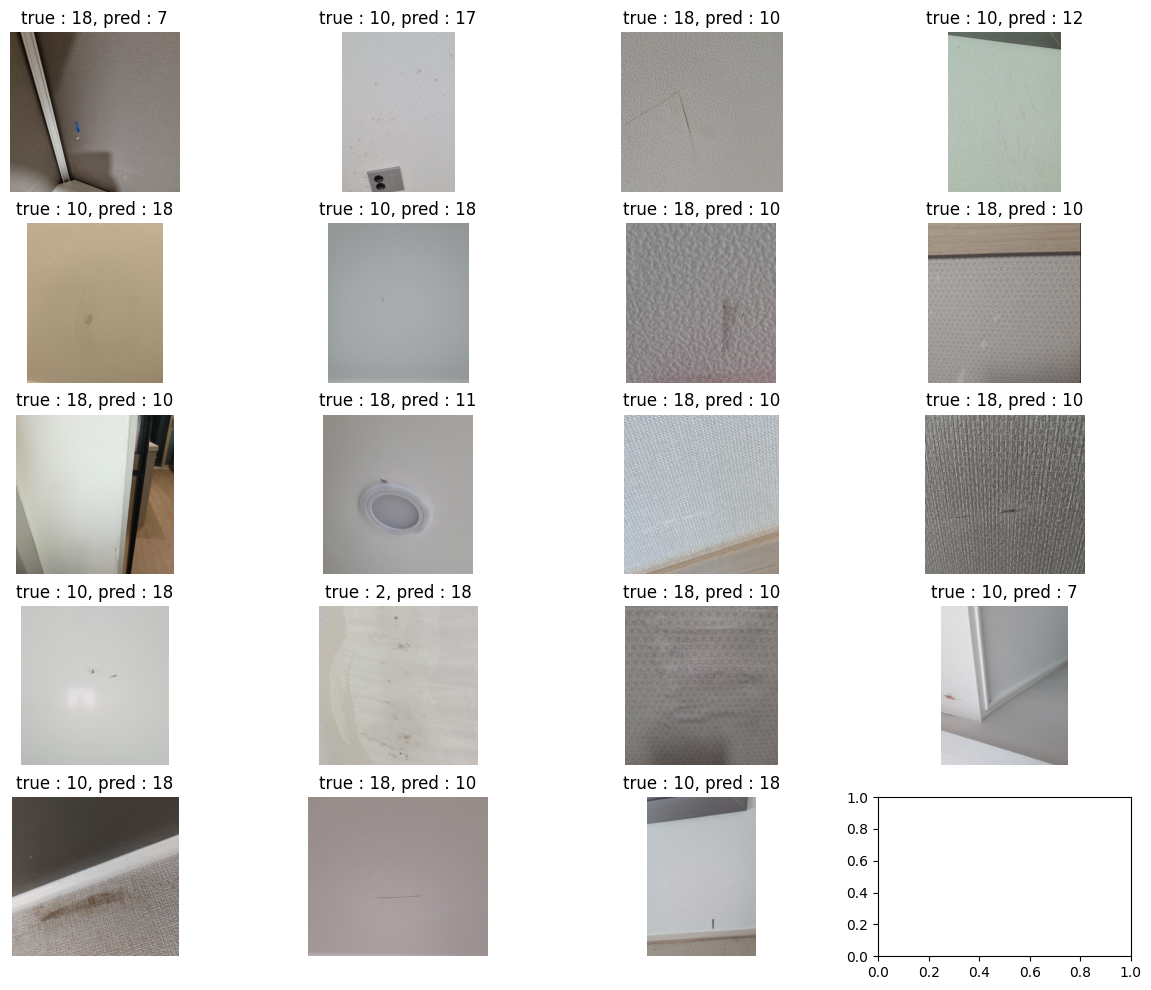

In [ ]:
plt.figure(figsize=(15,12))
for i in range(20):
    plt.subplot(5,4,i+1)
    im = Image.open(err_ds['img_path'].values[i])
    plt.imshow(im)
    plt.axis('off')
    tr = err_ds['label'].values[i]
    pr = err_ds['pred'].values[i]
    plt.title(f'true : {tr}, pred : {pr}')
plt.tight_layout()
plt.show()

In [ ]:
#test
test = pd.read_csv('drive/MyDrive/Doedal/test.csv')
test['img_path'] = test['img_path'].apply(lambda x: x.replace('./', 'drive/MyDrive/Doedal/', 1))

In [ ]:
test.head()

,id,img_path
0,TEST_000,drive/MyDrive/Doedal/test/000.png
1,TEST_001,drive/MyDrive/Doedal/test/001.png
2,TEST_002,drive/MyDrive/Doedal/test/002.png
3,TEST_003,drive/MyDrive/Doedal/test/003.png
4,TEST_004,drive/MyDrive/Doedal/test/004.png


In [ ]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

In [ ]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(test_loader):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [ ]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
preds

array([18, 10,  9,  7, 10, 18, 18, 18, 18, 11,  7, 11, 10, 10, 18, 10,  9,
        1, 18, 10, 10, 18, 18, 18, 14, 18,  6, 10, 18, 18, 18, 10, 18, 10,
        2, 18, 18, 18, 11, 18, 10,  5, 18,  6, 10, 18, 10, 18, 18, 10, 10,
       18, 18, 18, 18, 18, 18, 18, 18, 10, 11,  7, 18, 10, 18, 18, 10, 10,
       18, 10, 10, 10, 18, 18, 18, 18, 18, 10, 18, 10,  6, 18, 10, 18, 18,
       18, 18, 18, 10,  1, 10, 18, 18, 18, 18, 18, 18, 18, 18, 10, 17, 18,
       18, 15, 18, 18,  0, 10, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 10,
       18, 18, 18, 18, 10, 18, 18, 18, 18, 18, 18, 18, 18,  3, 10,  9, 10,
        6, 18, 18, 18, 18, 18, 10, 10, 18, 18,  6, 18, 15,  3, 18, 18, 18,
       18, 18, 13, 10, 18,  9,  9, 10, 18, 18, 18, 18, 18,  6, 10, 18, 18,
       18, 18, 18, 10, 10,  3, 10, 18, 18,  5, 18, 10, 10,  3, 10, 18,  3,
       18,  3, 18,  3, 18, 18, 10, 18,  2, 18, 13, 18, 10, 18,  3, 10, 18,
       14,  3, 18, 18, 10, 18,  3, 18, 18, 10, 18, 18, 18, 18, 15, 18, 18,
       18, 15, 10, 18, 10

In [ ]:
result = encoder.inverse_transform(preds)

In [ ]:
result

array(['훼손', '오염', '석고수정', '몰딩수정', '오염', '훼손',
       '훼손', '훼손', '훼손', '오타공', '몰딩수정', '오타공',
       '오염', '오염', '훼손', '오염', '석고수정',
       '걸레받이수정', '훼손', '오염', '오염', '훼손', '훼손',
       '훼손', '창틀,문틀수정', '훼손', '면불량', '오염',
       '훼손', '훼손', '훼손', '오염', '훼손', '오염', '곰팡이',
       '훼손', '훼손', '훼손', '오타공', '훼손', '오염', '들뜸',
       '훼손', '면불량', '오염', '훼손', '오염', '훼손', '훼손',
       '오염', '오염', '훼손', '훼손', '훼손', '훼손', '훼손',
       '훼손', '훼손', '훼손', '오염', '오타공', '몰딩수정',
       '훼손', '오염', '훼손', '훼손', '오염', '오염', '훼손',
       '오염', '오염', '오염', '훼손', '훼손', '훼손', '훼손',
       '훼손', '오염', '훼손', '오염', '면불량', '훼손', '오염',
       '훼손', '훼손', '훼손', '훼손', '훼손', '오염',
       '걸레받이수정', '오염', '훼손', '훼손', '훼손', '훼손',
       '훼손', '훼손', '훼손', '훼손', '오염', '피스', '훼손',
       '훼손', '터짐', '훼손', '훼손', '가구수정', '오염', '훼손',
       '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손',
       '훼손', '훼손', '오염', '훼손', '훼손', '훼손', '훼손',
       '오염', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손',
       '훼손', '훼손', '꼬임', '오염', '석고수정', '오염',
  

In [ ]:
#submission
submit = pd.read_csv('drive/MyDrive/Doedal/sample_submission.csv')

In [ ]:
submit['label'] = result

In [ ]:
submit.head()

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,석고수정
3,TEST_003,몰딩수정
4,TEST_004,오염


In [ ]:
import chardet

print(chardet.detect(submit['label'][0].encode()))

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [ ]:
# 인코딩 오류 수정하는 코드(자음 모음 분리 합쳐줌)
import unicodedata

for i in range(len(submit['label'])):
  submit['label'][i] = unicodedata.normalize('NFC',submit['label'][i])

In [ ]:
submit['label'][0]

'훼손'

In [ ]:
print(chardet.detect(submit['label'][0].encode()))

{'encoding': 'utf-8', 'confidence': 0.7525, 'language': ''}


In [ ]:
submit.to_csv('drive/MyDrive/Doedal/baseline_submit_1.csv', index=False)